# Causal ML with EconML

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import statsmodels.formula.api as smf
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import CausalForestDML
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OrdinalEncoder

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


We use the famuous diamonds dataset to study the relative price effect of giving a diamond an ideal cut (= treatment/intervention).

Typical questions in causal inference in the sense of Rubin and Imbens (2015):

1. How large is the average treatment effect $$\text{ATE} = \tau = \mathbb{E}(Y(1) - Y(0))?$$
$Y(1)$ and $Y(0)$ are the *potential outcomes* per treatment. Only one of them is observed in practice.
2. What are the main drivers of the *conditional* average treatment effect $$\text{CATE}(x) = \tau(x) = \mathbb{E}(Y(1) - Y(0) \mid X = x)$$ with respect to potential confounders $X$?

Data: $(Y_i(T_i), T_i, X_i), 1 \le i \le n$, where $T$ is the binary treatment assignment. 

We require a set of assumptions to be met:

- Unconfoundedness: Access to all confounders, i.e., to all variables that are associated with both $Y$ and the treatment $T$. Note that in a randomized experiment, there are no confounders (why?).
- Overlap: $E(T \mid X = x)$ is strictly between 0 and 1 for all $x$. We can make our population smaller to meet this condition.
- Stable unit treatment value assumption: Potential outcomes are independent of treatment assignments of other observations (more or less).

Since we are interested in *relative* effects, our $Y$ is log(price).

With small adaptions, the theory works also for continuous $T$. In this case, we make statements about one step increases in $T$ ("marginal effects"). This is relevant when studying price elasticity of a product, see e.g. https://github.com/py-why/EconML/blob/main/notebooks/CustomerScenarios/Case%20Study%20-%20Customer%20Segmentation%20at%20An%20Online%20Media%20Company%20-%20EconML%20%2B%20DoWhy.ipynb


## The dataset

In [2]:
df = sns.load_dataset("diamonds")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


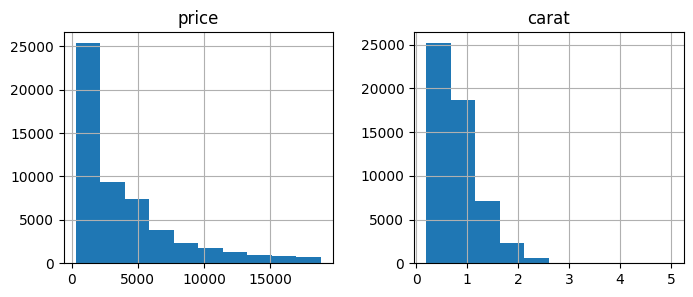

In [3]:
_ = df[["price", "carat"]].hist(figsize=(8, 3))

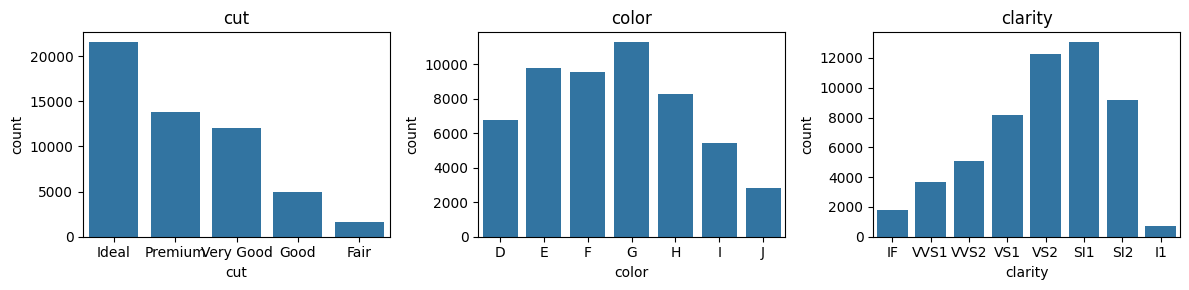

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
for x, ax in zip(["cut", "color", "clarity"], axes):
    sns.countplot(data=df, x=x, ax=ax).set_title(x)
fig.tight_layout()

## Define outcome and treatment

Our outcome is Y = log(price), and treatment is $T = 1$ if cut = "Ideal" and $T = 0$ otherwise.

In [5]:
df = df.assign(
    log_price=lambda x: np.log(x.price),
    cut_ideal=lambda x: (x.cut == "Ideal").astype(int),
)

## Linear regression

What treatment effect do we get with a linear regression? Note that we additionally assume that the model equation
$$
  \mathbb{E}(Y \mid X = x, T = t) = \alpha + \tau t + x\beta
$$
is correctly specified, an assumption that we later relax by ML.

Confounder adjusted effect of ideal cut is estimated as $\hat \tau = 0.045$. This means that getting an ideal cut is associated with about 5% higher prices. This is our first estimate of the ATE.


In [6]:
model = smf.ols(
    "log_price ~ cut_ideal + np.log(carat) + color + clarity", data=df
).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.960e+05
Date:                Sat, 04 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:23:01   Log-Likelihood:                 31015.
No. Observations:               53940   AIC:                        -6.200e+04
Df Residuals:                   53924   BIC:                        -6.185e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.0867      0.004   2318.320      0.000       9.079       9.094
color[T.E]         -0.0540      0.002    -25.070      0.000      -0.058      -0.050
color[T.F]         -0.0952      0.002    -43.663      0.000      -0.099      -0.091
color[T.G]         -0.1596      0.002    -74.815      0.000      -0.164      -0.155
color[T.H]         -0.2503      0.002   -110.572      0.000      -0.255      -0.246
color[T.I]         -0.3723      0.003   -146.772      0.000      -0.377      -0.367
color[T.J]         -0.5115      0.003   -163.511      0.000      -0.518      -0.505
clarity[T.VVS1]    -0.0943      0.004    -23.956      0.000      -0.102      -0.087
clarity[T.VVS2]    -0.1667      0.004    -44.315      0.000      -0.174      -0.159
clarity[T.VS1]     -0.3015      0.004    -83.941      0.000      -0.309      -0.295
clarity[T.VS2]     -0.3709      0.004   -105.752      0.000      -0.378      -0.364
clarity[T.SI1]     -0.5226      0.004   -148.026      0.000      -0.529      -0.516
clarity[T.SI2]     -0.6885      0.004   -187.312      0.000      -0.696      -0.681
clarity[T.I1]      -1.1448      0.006   -188.540      0.000      -1.157      -1.133
cut_ideal           0.0451      0.001     36.642      0.000       0.043       0.047
np.log(carat)       1.8827      0.001   1640.731      0.000       1.880       1.885
==============================================================================
Omnibus:                     2899.517   Durbin-Watson:                   1.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10434.922
Skew:                           0.158   Prob(JB):                         0.00
Kurtosis:                       5.131   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Now with causal ML

To get a refined estimate of the ATE, we use an advanced technique called "orthogonalized causal forest" from causal ML that provides us with a model for the CATE. This helps to identify segments that benefit most from getting an ideal cut.

The method consists of two stages:

1. Orthogonalization / Double ML: We fit two models to remove confounder effects from $Y$ and $T$. The first model (A) regresses the outcome $Y$ on $X$, the second model (B) regresses the treatment $T$ on $X$. This gives us confounder-free out-of-sample residuals $\tilde Y$ and $\tilde T$. We use random forests in this step, but we could also use boosted trees.
2. Causal forest: $\tilde Y$ is now regressed on $\tilde T$ and $X$ by a causal forest. This variant of usual random forests has multiple tweaks:
   - Each tree uses part of the data for splitting, and part of the data for predicting, effectively reduce overfitting. This approach is called "honesty".
   - Splits are done to maximize the difference between child node's treatment effects.
   - The model directly predicts CATE(x). Out-of-bag if calculated from training data.
   - A special variant of the Bootstrap is used to provide approximate confidence intervals for $\tau(x)$.
   - The model equation is $\tau(x) = f(T, X)$, where $f$ is estimated by the causal forest.

Note that we don't necessarily need to include all confounders in the second stage, but we need them in the first stage. 

In [7]:
# Prepare data for orthogonal causal forest
Y = df["log_price"]
T = df["cut_ideal"]

cat_vars = ["color", "clarity"]
ord_levels = [df[x].cat.categories.to_list() for x in cat_vars]

numeric_encoder = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(categories=ord_levels, dtype=int), cat_vars),
        ("num", "passthrough", ["carat"]),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")
X = numeric_encoder.fit_transform(df)
X.head()

,color,clarity,carat
0,1,6,0.23
1,1,5,0.21
2,1,3,0.23
3,5,4,0.29
4,6,6,0.31


In [8]:
residual_models_params = {
    "n_estimators": 500,
    "min_samples_leaf": 10,
    "max_features": "sqrt",
    "random_state": 6,
}

est = CausalForestDML(
    model_y=RandomForestRegressor(**residual_models_params, criterion="squared_error"),
    model_t=RandomForestClassifier(**residual_models_params, criterion="log_loss"),
    discrete_treatment=True,
    criterion="het",  # Splits maximize heterogeneity of treatment effects
    cv=5,  # For cross-fitting orthogonalization models
    mc_iters=1,  # Number of cross-fitting runs
    n_estimators=2000,
    min_samples_leaf=10,
    max_features="sqrt",
    subforest_size=4,  # n_estimators need to be divisible by this
    random_state=60,
    inference=True,
)

In [9]:
est.fit(Y=Y, T=T, X=X, W=None)  # W are confounders only used for orthogonalization
xvars = est.cate_feature_names()  # X.columns

In [10]:
# Note: Scores of the residual models (one cross-fitting run)
# est.models_t[0][0].score(X, y=T), est.models_y[0][0].score(X, y=Y)

## ATE

The estimate $\hat \tau$ of the ATE is slightly higher than the one obtained by linear regression.

In [11]:
# Plain average CATE
# est.ate_inference(X)

In [12]:
# Augmented inverse propensity weighted estimate
print("Point estimate of the ATE", est.ate_)
est.summary()

Point estimate of the ATE [0.05464944]
Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.055,0.001,42.974,0.0,0.052,0.057
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.059,0.001,49.317,0.0,0.057,0.061
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.048,0.003,18.386,0.0,0.043,0.053


## CATE

(OOB) predictions of the causal random forests can be read as individual treatment effects. The statistical inference, however, refers to its expectation.

In [13]:
est.effect_inference(X.head()).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,-0.003,0.020,-0.162,0.871,-0.042,0.036
1,0.045,0.025,1.777,0.076,-0.005,0.095
2,0.194,0.029,6.616,0.000,0.136,0.251
3,0.020,0.022,0.948,0.343,-0.022,0.063
4,-0.033,0.023,-1.438,0.150,-0.077,0.012


In [14]:
# Effect when increasing treatment by 1 (interesting only with continuous treatment)
est.const_marginal_effect_inference(X.head()).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,-0.003,0.020,-0.162,0.871,-0.042,0.036
1,0.045,0.025,1.777,0.076,-0.005,0.095
2,0.194,0.029,6.616,0.000,0.136,0.251
3,0.020,0.022,0.948,0.343,-0.022,0.063
4,-0.033,0.023,-1.438,0.150,-0.077,0.012


### Interpreting the CATE model

We use classic explainability methods (global surrogate tree, split gain importance, partial dependence) as well as SHAP to study the estimatred CATE model $\hat \tau(x)$.

We can see that the strongest impact on the treatment effect comes from carat, but it is highly non-monotonic. The worse the color, the smaller the effect of an ideal cut.

#### Global surrogate tree

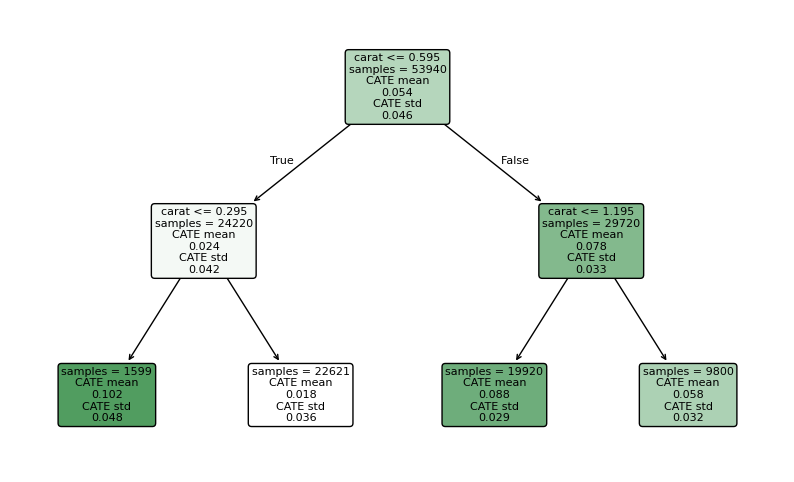

In [15]:
intrp = SingleTreeCateInterpreter(max_depth=2)
intrp.interpret(est, X)
plt.figure(figsize=(10, 6))
intrp.plot(feature_names=xvars, fontsize=8)

#### Split gain importance

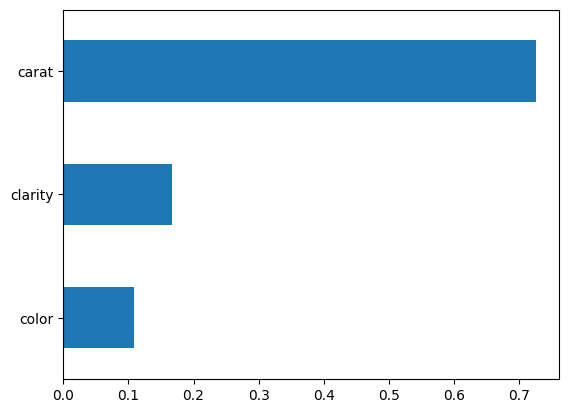

In [16]:
_ = (
    pd.Series(est.feature_importances_, index=est.cate_feature_names())
    .sort_values()
    .plot.barh()
)

#### Partial dependence

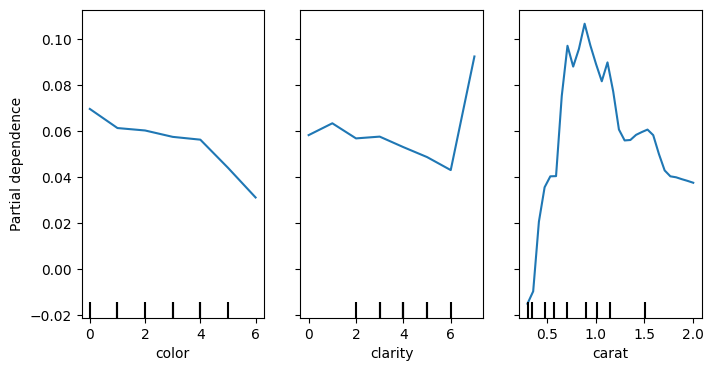

In [17]:
fig, axes = plt.subplots(figsize=(8, 4), squeeze=True)

est.model_cate._estimator_type = "regressor"  # Scikit-Learn, oh well

_ = PartialDependenceDisplay.from_estimator(
    est.model_cate,
    features=xvars,
    feature_names=xvars,
    X=X.sample(500, random_state=10),
    grid_resolution=30,
    n_cols=4,
    ax=axes,
)

#### SHAP

SHAP values are on centered prediction scale.

In [18]:
X_explain = X.sample(500, random_state=10)

# Background samples are used for *interventional* TreeSHAP
S = est.shap_values(
    X_explain, output_names="Y", treatment_names="T_1", background_samples=100
)["Y"]["T"]

Tree explainer!
(100, 3)


 99%|===================| 496/500 [02:05<00:01]        

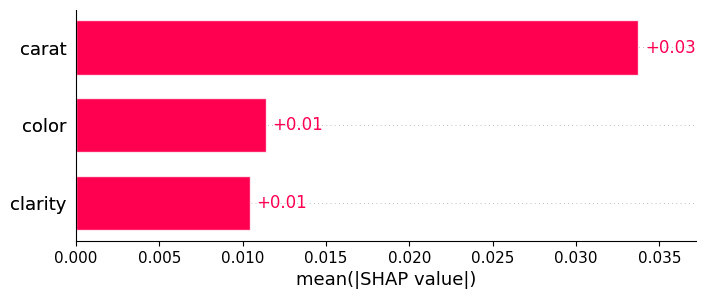

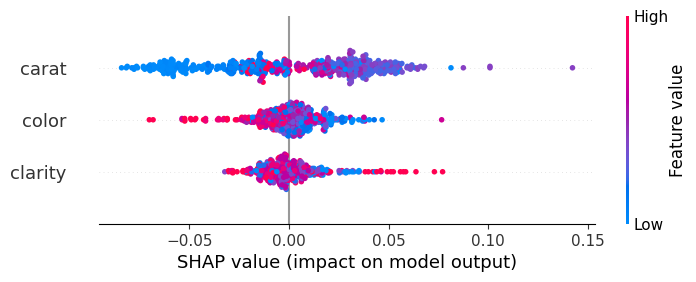

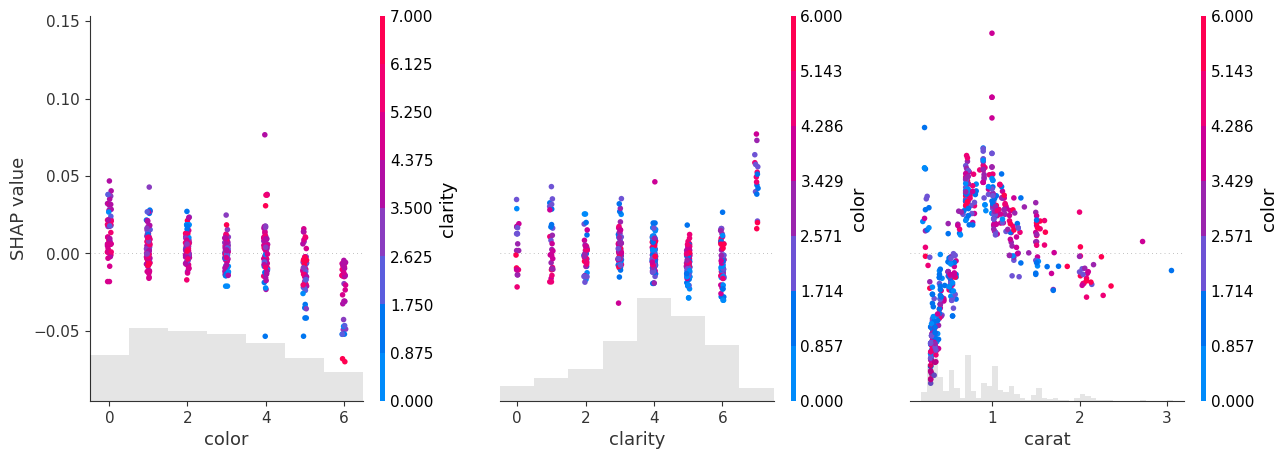

In [19]:
shap.plots.bar(S)
shap.plots.beeswarm(S)
shap.plots.scatter(S, color=S)